In [3]:
!pip install nltk
!pip install emoji
!pip install Sastrawi
!pip install naive_bayes

import pandas as pd
import numpy as np
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# NLP
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import emoji

# Viz
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

# Model Naive Bayes
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model, metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from collections import defaultdict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df_path = 'flip.tsv'
kamus_alay_path = 'kamus_alay.csv'
df = pd.read_csv(df_path, sep='\t', names=['komentar', 'sentimen'])
df.info()
print(f'shape: {df.shape}')
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   komentar  2700 non-null   object
 1   sentimen  2700 non-null   object
dtypes: object(2)
memory usage: 42.3+ KB
shape: (2700, 2)


,komentar,sentimen
1089,Baru mau coba,neutral
1787,3 bintang dulu lah gk tau cara,neutral
680,Awal y bagus Giliran kesini gagal trus pdahal ...,negative
2264,Powerfullhemat luar biasa semoga aman terus,positive
1152,Ok kita buka dl,neutral


In [ ]:
# Cek Data Kosong
df.isnull().sum()

komentar    0
sentimen    0
dtype: int64

In [ ]:
df.empty

False

In [ ]:
# Proporsi Variabel Target
df['sentimen'].value_counts()

negative    900
neutral     900
positive    900
Name: sentimen, dtype: int64

Text(0, 0.5, 'Total Sentimen')

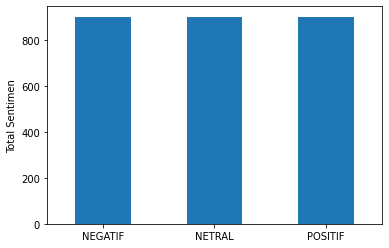

In [ ]:
#Visualisasi data
# VISUALISASI BAR
category = df['sentimen']. value_counts().plot(kind='bar')
group_labels = ['NEGATIF', 'NETRAL', 'POSITIF']
category.set_xticklabels(group_labels)
plt.xticks(rotation=0)
plt.ylabel("Total Sentimen")

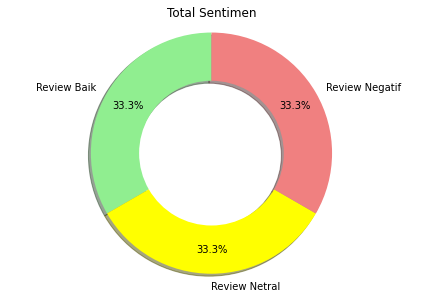

In [ ]:
# VISUALISASI DONAT
def donut(sizes, ax, angle=90, labels=None,colors=None, explode=None, shadow=None):

    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%', 
           startangle = angle, pctdistance=0.8, explode = explode, 
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')  
    plt.tight_layout()

# Plot arguments
sizes = df.sentimen.value_counts()
labels = ['Review Baik', 'Review Netral', 'Review Negatif']
colors = ['lightgreen', 'yellow', 'lightcoral']
explode = (0,0,0)

# Create axes
f, ax = plt.subplots(figsize=(6,4))

# plot donut
donut(sizes, ax, 90, labels, colors=colors, explode=explode, shadow=True)
ax.set_title('Total Sentimen')
plt.show()

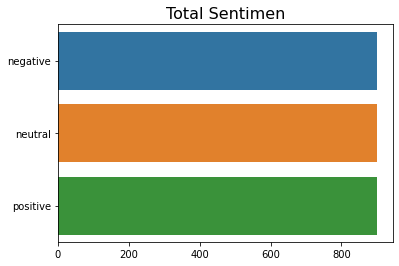

In [ ]:
count = [count for count in df['sentimen'].value_counts()]
labels = list(df['sentimen'].value_counts().index)

plt.title('Total Sentimen', fontsize = 16)
sns.barplot(x=count, y=labels, data=df)

<function matplotlib.pyplot.show>

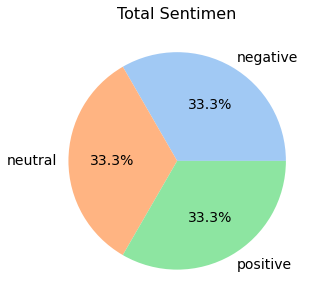

In [ ]:
fig, ax = plt.subplots(figsize = (5, 5))
colors = sns.color_palette('pastel')

count_rating = [count for count in df['sentimen'].value_counts()]
labels_rating = list(df['sentimen'].value_counts().index)

plt.title('Total Sentimen', fontsize = 16)
ax.pie(x=count_rating, labels=labels_rating, autopct = '%1.1f%%', 
       textprops={'fontsize': 14}, colors=colors)
plt.show

In [ ]:
# Insert new stop words
old_stopwords = stopwords.words('indonesian')
new_stopwords = ["flip", "transfer", "transaksi", "bintang", "masuk", "uang", "udah", "gk", "ga", "gak", "kirim", "ktp",
                 "aplikasi", "app", "nya", "yg", "ya", "bank", "jenius", "neo", "raya", "tmrw", "syariah", "tdk",
                 "dbs", "line bank", "linebank", "livin", "wokee", "seabank", "jago", "blu", "yng", "saldo", 'akun',
                 'aolikasi', 'apliksix', 'aja', 'apk', 'apps', 'dgn', 'ane', 'sy', 'gua', 'gwa', 'si', "biaya",
                 'smpai', 'bgt', 'banget', 'bangettt', 'tu', 'ama', 'utk', 'udh', 'btw', 'ntar', 'lol', 'proses', 'verifikasi',
                 'ttg', 'emg', 'aj', 'tll', 'sih', 'kalo', 'klo', 'trsa', 'mnrt', 'nih', 'ma', 'dr', 'ajaa',
                 'tp', 'akan', 'bs', 'bikin', 'kta', 'pas', 'pdahl', 'bnyak', 'guys', 'tnx', 'bang', 'nang',
                 'mas', 'amat', 'tjoy', 'hemm', 'haha', 'sllu', 'hrs', 'lanjut', 'bgtu', 'sbnrnya', 'trjadi',
                 'pdhl', 'sm', 'plg', 'skrg', 'ny', 'bca', 'mandiri', 'bri', 'btpn', 'dbs', 'brimo', 
                 "admin", 'gimana', 'dlu', 'jam', 'isi', 'foto', "pakai", "pake", 'refund', 'bukti', 'tf', 'cs', 
                 'kali', 'btn', 'min', 'download', 'blm', 'tau', 'rekening', 'salah', 'dana', 'data', 'buka', 'daftar',
                 'kode', 'unik', 'sya', 'top', 'up', 'chat', 'email', 'nggak', "deh", "kasih", "kak", "tolong", "cek",
                 "langsung", "menit", "respon", "balas", "gue", "orang", "terima", "suruh", "hubung", "nunggu", "tunggu",
                 "tambah", "bilang", "install", "coba"]

new_stopwords = new_stopwords + old_stopwords

In [ ]:
kamus_alay = pd.read_csv(kamus_alay_path)

normalize_word_dict = {}
for index, row in kamus_alay.iterrows():
    if row[0] not in normalize_word_dict:
        normalize_word_dict[row[0]] = row[1]

In [ ]:
# Pre-processing

character = ['.',',',';',':','-,','...','?','!','(',')','[',']','{','}','<','>','"','/','\'','#','-','@',
             'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

def repeatcharClean(text):
# hapus karakter yang berulang
   for i in range(len(character)):
    charac_long = 5
    while charac_long > 2:
      char = character[i]*charac_long 
      text = text.replace(char,character[i])
      charac_long -= 1
      return text

In [ ]:
# Pre-processing

def cleaningText(text):
# hapus karakter yang berulang
   for i in range(len(character)):
    charac_long = 5
    while charac_long > 2:
      char = character[i]*charac_long 
      text = text.replace(char,character[i])
      charac_long -= 1
    # hapus emoji
    text = emoji.demojize(text)
    text = re.sub(':[A-Za-z_-]+:', '', text)
    # hapus emoticon
    text = re.sub(r"([xX;:]'?[dDpPvVoO3)(])", '', text)
    # hapus username dan mentions
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r"@[^\s]+[\s]?", ' ', text)
    # hapus hashtag
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'#(\S+)', r'\1', text)
    # hapus link
    text = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", text)
    # hapus angka dan simbol
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub('[^a-zA-Z,.?!]+',' ',text)
    # hapus karakter berulang
    text = repeatcharClean(text)
    # hapus spasi
    text = re.sub('[ ]+',' ',text)
    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower() 
    return text

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text) 
    #ubah bahasa alay
    text = [normalize_word_dict[term] if term in normalize_word_dict else term for term in text]
    return text

def filteringText(text): # Remove stopwords in a text
    listStopwords = set(new_stopwords)
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered 
    return text

def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in text]
    return text

def toSentence(text): # Convert list of words into sentence
    text = ' '.join(word for word in text)
    return text

df['text_clean'] =df['komentar'].apply(cleaningText)
df['text_clean'] = df['text_clean'].apply(casefoldingText)

df['text_preprocessed'] = df['text_clean'].apply(tokenizingText)
df['text_preprocessed'] = df['text_preprocessed'].apply(filteringText)
df['text_preprocessed'] = df['text_preprocessed'].apply(stemmingText)

df.to_csv('cleaned.csv', index=False)

In [4]:
df = pd.read_csv('cleaned79.csv')
df

,komentar,sentimen,text_clean,text_preprocessed
0,Busuk lemot parah,negative,busuk lemot parah,"['busuk', 'lambat', 'parah']"
1,LEMOT,negative,lemot,['lambat']
2,Aplikasi ribet,negative,aplikasi ribet,['ribet']
3,Burukkkkkkk,negative,burukkkkkkk,['burukkkkkkk']
4,Error,negative,error,['error']
...,...,...,...,...
2578,bagus aplikasi mudah digunakan cm kekurangan ...,positive,bagus aplikasi mudah digunakan cm kekurangan t...,"['bagus', 'mudah', 'kurang', 'proses', 'bagus'..."
2579,Untuk pertama kali pakai lumayan menghemat bia...,positive,untuk pertama kali pakai lumayan menghemat bia...,"['lumayan', 'hemat', 'ribet', 'bolak', 'aplkas..."
2580,Hehe lumayan ngirit 6500😁😁💰,positive,hehe lumayan ngirit,"['hehe', 'lumayan', 'ngirit']"
2581,Bagus banget,positive,bagus banget,['bagus']


In [ ]:
# Import Train Test Split
from sklearn.model_selection import train_test_split

# Multinomial Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB

# Import Tf-idf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Import the Label Encoder
from sklearn.preprocessing import LabelEncoder

# To evaluate our model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [ ]:
# Initialize the Label Encoder.
le = LabelEncoder()

# Encode the categories
df['sentimen_enc'] = le.fit_transform(df['sentimen'])

# Display the first five rows again to see the result
display(df.sample(10))

,komentar,sentimen,text_clean,text_preprocessed,sentimen_enc
2379,Sangat membantu terutama untuk meminimalkan se...,positive,sangat membantu terutama untuk meminimalkan se...,"['bantu', 'minimal', 'selisih']",2
179,lama sekali untuk melakukan transaksi bak kend...,negative,lama sekali untuk melakukan transaksi bak kend...,"['bak', 'kendalany', 'lambat', , 'susah', 'cep...",0
2181,Mantap,positive,mantap,['mantap'],2
1720,Amanah dan terpercaya,positive,amanah dan terpercaya,"['amanah', 'percaya']",2
1566,hy flip gmn sih udah transfer bener kt salah ...,negative,hy flip gmn sih udah transfer bener kt salah h...,"['hai', , 'respond', 'telepon', 'angkat', 'buk...",0
1921,Mudah hematAman dan man dalam bertransaksi,positive,mudah hemataman dan man dalam bertransaksi,"['mudah', 'hemataman', 'man', 'transaksi']",2
1042,Cba dlu klo baik nanty saya tambh bintangya jdi5,neutral,cba dlu klo baik nanty saya tambh bintangya jdi,"['coba', 'nanty', 'tambh', 'bintangya']",1
1421,Saya suka apk ini tapi verifikasi akun sulit,neutral,saya suka apk ini tapi verifikasi akun sulit,"['suka', 'sulit']",1
569,Respon lama bener 1 jam dari mana yg ada 2 jam...,negative,respon lama bener jam dari mana yg ada jam leb...,"[, 'geram', 'selesai', 'fitur', 'tarik']",0
1283,Transfer ke rek sinar mas kenapa blum bisa ya,negative,transfer ke rek sinar mas kenapa blum bisa ya,"['rek', 'sinar', 'blum']",0


In [ ]:
df['sentimen_enc'] = LabelEncoder().fit_transform(df['sentimen'].values)
df

,komentar,sentimen,text_clean,text_preprocessed,sentimen_enc
0,Busuk lemot parah,negative,busuk lemot parah,"['busuk', 'lambat', 'parah']",0
1,LEMOT,negative,lemot,['lambat'],0
2,Aplikasi ribet,negative,aplikasi ribet,['ribet'],0
3,Burukkkkkkk,negative,burukkkkkkk,['burukkkkkkk'],0
4,Error,negative,error,['error'],0
...,...,...,...,...,...
2552,bagus aplikasi mudah digunakan cm kekurangan ...,positive,bagus aplikasi mudah digunakan cm kekurangan t...,"['bagus', 'mudah', 'kurang', 'proses', 'bagus'...",2
2553,Untuk pertama kali pakai lumayan menghemat bia...,positive,untuk pertama kali pakai lumayan menghemat bia...,"['lumayan', 'hemat', 'ribet', 'bolak', 'aplkas...",2
2554,Hehe lumayan ngirit 6500😁😁💰,positive,hehe lumayan ngirit,"['hehe', 'lumayan', 'ngirit']",2
2555,Bagus banget,positive,bagus banget,['bagus'],2


In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

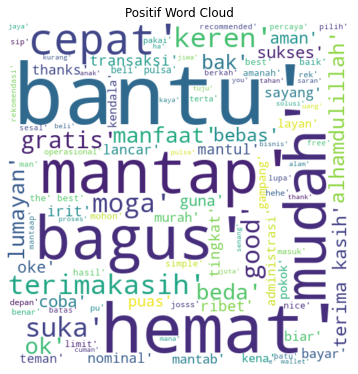

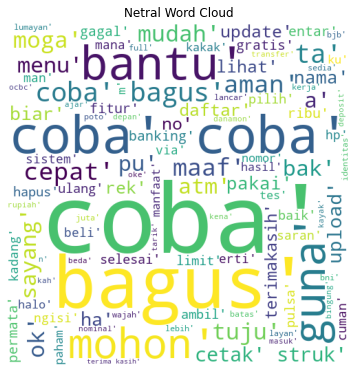

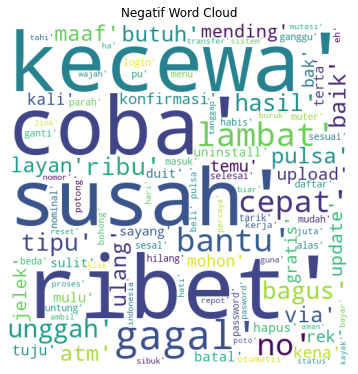

In [ ]:
# Positif
positif = df[df['sentimen']=='positive']['text_preprocessed'].str.cat(sep=', ')

# Netral
netral = df[df['sentimen']=='neutral']['text_preprocessed'].str.cat(sep=', ')

# Negatif
negatif = df[df['sentimen']=='negative']['text_preprocessed'].str.cat(sep=', ')

# Initialize the word cloud
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color ='white')

# Generate the world clouds for each type of comments
positif_wc = wc.generate(positif)

# plot the world cloud for spam                     
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(positif_wc, interpolation="bilinear") 
plt.axis("off") 
plt.title("Positif Word Cloud")
plt.tight_layout(pad = 0) 
plt.show() 
print('')

# Generate the world clouds for each type of comments
netral_wc = wc.generate(netral)

# plot the world cloud for spam                       
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(netral_wc) 
plt.axis("off")
plt.title("Netral Word Cloud")
plt.tight_layout(pad = 0) 
plt.show() 
print('')


# Generate the world clouds for each type of comments
negatif_wc = wc.generate(negatif)

# plot the world cloud for spam                       
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(negatif_wc) 
plt.axis("off")
plt.title("Negatif Word Cloud")
plt.tight_layout(pad = 0) 
plt.show()

In [ ]:
# Select the features and the target
x = df['text_preprocessed']
y = df['sentimen_enc']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
print ('Train set: ', X_train.shape, y_train.shape)
print ('Test set: ', X_test.shape, y_test.shape)

Train set:  (2066,) (2066,)
Test set:  (517,) (517,)


In [ ]:
# Create the tf-idf vectorizer
vectorizer = TfidfVectorizer()

# First fit the vectorizer with our training set
tfidf_train = vectorizer.fit_transform(X_train)

# Now we can fit our test data with the same vectorizer
tfidf_test = vectorizer.transform(X_test)

In [ ]:
# Initialize the Multinomial Naive Bayes classifier
nb = MultinomialNB()

# Fit the model
params = {'alpha': [2]}
multinomial_nb_grid = GridSearchCV(nb, param_grid=params, n_jobs=-1, cv=5, verbose=1)
multinomial_nb_grid.fit(tfidf_train, y_train)

# Print the accuracy score
print("Accuracy:",multinomial_nb_grid.score(tfidf_test, y_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Accuracy: 0.7350096711798839


In [ ]:
# Predict the labels
y_pred = multinomial_nb_grid.predict(tfidf_test)

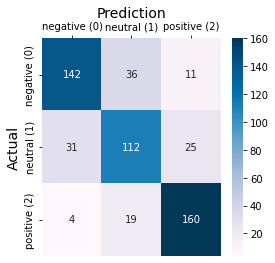



Classification Report

              precision    recall  f1-score   support

           0       0.80      0.75      0.78       189
           1       0.67      0.67      0.67       168
           2       0.82      0.87      0.84       183

    accuracy                           0.77       540
   macro avg       0.76      0.76      0.76       540
weighted avg       0.77      0.77      0.77       540



In [ ]:
# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize = (4, 4))
sns.heatmap(cm, fmt = 'g', annot = True, cmap="PuBu")
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediction', fontsize = 14)
ax.set_xticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
ax.set_ylabel('Actual', fontsize = 14)
ax.set_yticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
plt.show()

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)